In [2]:
'''
compute the log prob increase of all heads, and their true label attn - false label attn (for binary classification tasks)
'''
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import TraceDict

device="cuda:1"
model_path = "/home/pc/data/qixun/checkpoints/llama-2-7b"
model = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
MAX_NEW_TOKENS=2

def cal_log_pred_prob(target_word, model, tokenizer, rep, word_embeddings):
    assert rep.shape == torch.Size([model.config.hidden_size])
    target_token=tokenizer(target_word, return_tensors='pt')['input_ids'].squeeze().to(device)
    assert target_token.shape[0]==2 # some target words may longer than 1 token
    target_token=target_token[1] # target_token[0] is <s>
    target_word_embedding=word_embeddings[target_token]
    sum_exp=torch.sum(torch.exp(torch.sum(word_embeddings * rep, dim=1)), dim=0)
    target_exp=torch.exp(torch.dot(target_word_embedding, rep))
    log_prob=torch.log(target_exp/sum_exp)
    return log_prob

def get_output_text(model, tokenizer, prompt, device):
    input_tks = tokenizer(prompt, return_tensors='pt').to(device)
    output_tokens = model.generate(input_tks.input_ids, top_p=0.9, temperature=0.1,
                                max_new_tokens=MAX_NEW_TOKENS)
    output_text = tokenizer.decode(output_tokens.squeeze()[-MAX_NEW_TOKENS:])
    return output_text

def get_tokens(model, tokenizer, prompt, device):
    tokens = tokenizer(prompt, return_tensors='pt').to(device)
    return tokens['input_ids']

def get_tk_words(tokenizer, tks):
    '''
    map the tokens back to the words. original words may be split.
    '''
    tk_words=[]
    for i in range(tks.shape[0]):
        tk_words.append(tokenizer.decode(tks[i]))
    return tk_words

In [4]:
tk=get_tokens(model, tokenizer, "revolutionary: positive\nbad: negative\ninsightful: positive\nselfish: negative\nbeautiful: positive\noutdated: negative\nclean: ", device)
print(tk)
tk=get_tokens(model, tokenizer, "positive", device)
print(tk)

tensor([[    1, 19479,   653, 29901,  6374,    13, 12313, 29901,  8178,    13,
          1144,   523,  1319, 29901,  6374,    13,  1311,   728, 29901,  8178,
            13,   915,  1300,  6845, 29901,  6374,    13,   449,  9715, 29901,
          8178,    13, 14941, 29901, 29871]], device='cuda:1')
tensor([[   1, 6374]], device='cuda:1')


In [9]:
task='ss_neg' # which prompt to test
attn_obj='labels' # labels: compute the attn between the last token's Q and context's labels'K; all: compute the attn between the last token's Q and all context tokens'K
spec_str='' # flexible str to mark the saved figures
ana_module='by_head' # all heads: compute the attn of all heads; by_head: compute the attn of the most significant heads
sftmx=True

if task=='a':
    task_name="antonym"
    prompt="difficult: easy\nwrong: right\ngood: bad\nwin: lose\ndangerous: safe\nfast:"
    target_word="slow"
elif task=='cs_bar':
    task_name="classification_symbol_bar"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\none:"
    target_word="bar"
elif task=='cs_foo':
    task_name="classification_symbol_foo"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\njump:"
    target_word="foo"
elif task=='ss_pos':
    task_name="simple_sentiment"
    prompt="revolutionary: positive\nbad: negative\ninsightful: positive\nselfish: negative\nbeautiful: positive\noutdated: negative\nclean: "
    spec_str+="_pos"
    target_word="positive"
elif task=='ss_neg':
    task_name="simple_sentiment"
    prompt="revolutionary: positive\nbad: negative\ninsightful: positive\nselfish: negative\nbeautiful: positive\noutdated: negative\nvulgar: "
    spec_str+='_neg'
    target_word="negative"
elif task=='sss_pos':
    task_name="simple_sentiment_symbol"
    prompt="good: foo\nbad: bar\ninsightful: foo\nselfish: bar\nbeautiful: foo\nboring: bar\nstrong: "
    spec_str+='_pos2'
    target_word="foo"
elif task=='sss_neg':
    task_name="simple_sentiment_symbol"
    prompt="good: foo\nbad: bar\ninsightful: foo\nselfish: bar\nbeautiful: foo\nboring: bar\nvulgar: "
    spec_str+='_neg'
    target_word="bar"
elif task=='ss2':
    task_name="simple_sentiment_2_words"
    prompt="revolutionary idea: positive\nbad ass: negative\ninsightful finding: positive\nselfish man: negative\nbeautiful bird: positive\noutdated book: negative\nfilthy idea: "
    target_word="negative"

    
input_tokens = tokenizer(prompt, return_tensors='pt').to(device)
n_layers=model.config.num_hidden_layers
n_heads=model.config.num_attention_heads
hidden_dim=model.config.hidden_size
head_dim=hidden_dim//n_heads
attn_O=[f'model.layers.{l}.self_attn.o_proj' for l in range(n_layers)]
attn_V=[f'model.layers.{l}.self_attn.v_proj' for l in range(n_layers)]
attn_Q=[f'model.layers.{l}.self_attn.q_proj' for l in range(n_layers)]
attn_K=[f'model.layers.{l}.self_attn.k_proj' for l in range(n_layers)]
n_top_layers=10
n_top_heads=20

word_embeddings=model.get_input_embeddings().weight
layer_prob_increase_storage=torch.zeros(n_layers).to(device)
head_prob_increase_storage=torch.zeros(n_layers, n_heads).to(device)
head_attn_diff_storage=torch.zeros(n_layers, n_heads).to(device)
tks=get_tokens(model, tokenizer, prompt, device).squeeze(0)
if target_word=='bar':
    target_label_poss=torch.where(tks==2594)[0]
    contras_label_poss=torch.where(tks==7953)[0]
elif target_word=='foo':
    target_label_poss=torch.where(tks==7953)[0]
    contras_label_poss=torch.where(tks==2594)[0]
elif target_word=='positive':
    target_label_poss=torch.where(tks==6374)[0]
    contras_label_poss=torch.where(tks==8178)[0]
elif target_word=='negative':
    target_label_poss=torch.where(tks==8178)[0]
    contras_label_poss=torch.where(tks==6374)[0]

with TraceDict(model, layers=attn_O+attn_Q+attn_V+attn_K, retain_input=True, retain_output=True) as rep:
    model(**input_tokens)
    for l in range(n_layers):
        before_O=rep[attn_O[l]].input.squeeze(0)[-1,:] # last token rep
        after_O=rep[attn_O[l]].output.squeeze(0)[-1,:] # last token rep
        layer_prob_increase=cal_log_pred_prob(target_word, model, tokenizer, after_O, word_embeddings)\
                            - cal_log_pred_prob(target_word, model, tokenizer, before_O, word_embeddings)
        layer_prob_increase_storage[l]=layer_prob_increase
        for h in range(n_heads):
            head_before_O=before_O[h*head_dim:(h+1)*head_dim] # this should be QK/sqrt(d)*V[h]
            head_after_O=torch.mm(head_before_O.view(1, -1), model.model.layers[l].self_attn.o_proj.weight[h*head_dim:(h+1)*head_dim, :]).squeeze(0)
            head_prob_increase = cal_log_pred_prob(target_word, model, tokenizer, head_after_O, word_embeddings)\
                                - cal_log_pred_prob(target_word, model, tokenizer, before_O, word_embeddings)
            head_prob_increase_storage[l,h]=head_prob_increase

            last_token_Q=rep[attn_Q[l]].output.squeeze(0)[-1, h*head_dim:(h+1)*head_dim] # print(last_token_Q.shape) = [128], i.e., [head_dim]
            target_label_K=rep[attn_K[l]].output.squeeze(0)[target_label_poss, h*head_dim:(h+1)*head_dim] 
            contras_label_K=rep[attn_K[l]].output.squeeze(0)[contras_label_poss, h*head_dim:(h+1)*head_dim] 
            target_attn_scores=torch.mm(target_label_K, last_token_Q.view(-1,1)).view(len(target_label_poss)).sum(0)
            contras_attn_scores=torch.mm(contras_label_K, last_token_Q.view(-1,1)).view(len(contras_label_poss)).sum(0)
            if sftmx:
                attn_score=torch.softmax(torch.cat((target_attn_scores.unsqueeze(0), contras_attn_scores.unsqueeze(0)), dim=0), dim=0)
                head_attn_diff_storage[l,h]=attn_score[0]-attn_score[1]
            else:   
                head_attn_diff_storage[l,h]=target_attn_scores-contras_attn_scores



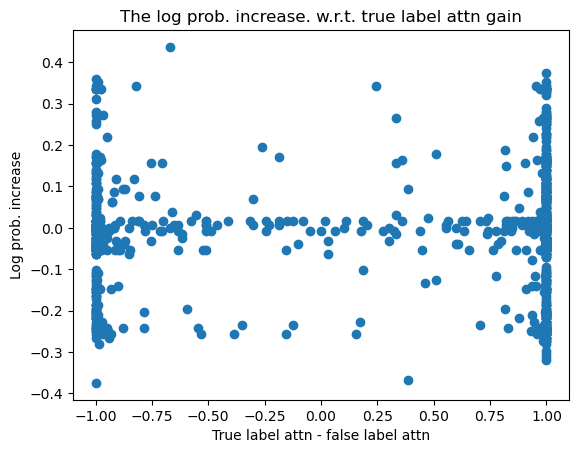

In [10]:
import numpy as np
import matplotlib.pyplot as plt

if sftmx:
    spec_str+='_sftmx'

plt.scatter(head_attn_diff_storage.view(-1).detach().cpu().numpy(),  head_prob_increase_storage.view(-1).detach().cpu().numpy())
plt.savefig(f'./visualization/attn/by_head/traverse/attn_diff_wrt_prob_increase_'+task_name+spec_str+'.jpg')
plt.savefig(f'./visualization/attn/by_head/traverse/attn_diff_wrt_prob_increase_'+task_name+spec_str+'.pdf')
plt.title('The log prob. increase. w.r.t. true label attn gain')
plt.xlabel('True label attn - false label attn')
plt.ylabel('Log prob. increase')
plt.show()